torch.Size([1, 2048, 7, 7])


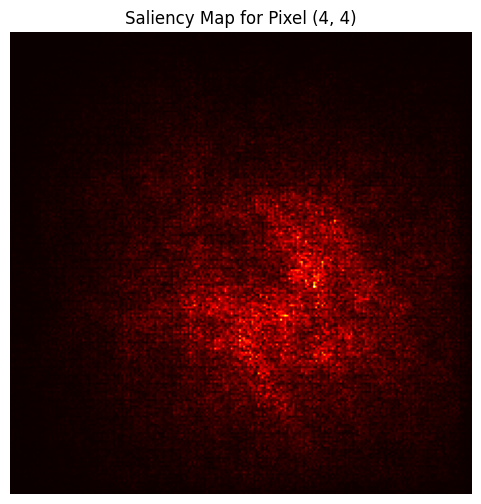

In [27]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load a pre-trained ResNet model and remove the fully connected layers
class ResNetWithoutFNN(nn.Module):
    def __init__(self):
        super(ResNetWithoutFNN, self).__init__()
        # Load the pre-trained ResNet
        self.model = models.resnet50(pretrained=False)
        # Remove the fully connected layer by keeping everything up to 'avgpool'
        self.features = nn.Sequential(*list(self.model.children())[:-2])  # All CNN layers

    def forward(self, x):
        x = self.features(x)
        return x

# Preprocess the image (resizing and normalization)
def preprocess_image(img_path):
    img = Image.open(img_path).convert('RGB')
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension
    return img_tensor

# Generate the saliency map for a specific feature map pixel
def generate_saliency_map_for_pixel(img_tensor, model, target_layer_pixel):
    img_tensor.requires_grad_()  # Enable gradients for input
    output = model(img_tensor)  # Forward pass through CNN layers
    print(output.shape)
    
    # Select the target pixel from the feature map (height, width) coordinates
    h, w = target_layer_pixel
    target_feature = output[0, :, h, w]  # Select the specific pixel at (h, w)
    
    # Sum the feature map pixel values to treat it as a scalar target for gradients
    scalar_target = target_feature.sum()
    model.zero_grad()
    
    # Backpropagate the gradient from this pixel
    scalar_target.backward()
    
    # Get the gradient of the input image
    saliency, _ = torch.max(img_tensor.grad.data.abs(), dim=1)  # Max across color channels
    saliency = saliency.squeeze().cpu().numpy()  # Convert to numpy
    
    return saliency

# Plot and visualize the saliency map
def visualize_saliency_map_for_pixel(img_path, target_layer_pixel=(4, 4)):
    model = ResNetWithoutFNN()
    model.eval()  # Set model to evaluation mode
    
    img_tensor = preprocess_image(img_path)
    saliency = generate_saliency_map_for_pixel(img_tensor, model, target_layer_pixel)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(saliency, cmap='hot')
    plt.axis('off')
    plt.title(f'Saliency Map for Pixel {target_layer_pixel}')
    plt.show()

# Provide your image path and target pixel
image_path = 'your_image.png'
target_layer_pixel = (4, 4)  # Specify the pixel coordinates in the feature map
visualize_saliency_map_for_pixel(image_path, target_layer_pixel)


In [ ]:

# Generate the saliency map for a specific feature map pixel
def generate_saliency_map_for_pixel(img_tensor, model, target_layer_pixel):
    img_tensor.requires_grad_()  # Enable gradients for input
    output = model(img_tensor)  # Forward pass through CNN layers
    print(output.shape)
    
    # Select the target pixel from the feature map (height, width) coordinates
    h, w = target_layer_pixel
    target_feature = output[0, :, h, w]  # Select the specific pixel at (h, w)
    
    # Sum the feature map pixel values to treat it as a scalar target for gradients
    scalar_target = target_feature.sum()
    model.zero_grad()
    
    # Backpropagate the gradient from this pixel
    scalar_target.backward()
    
    # Get the gradient of the input image
    saliency, _ = torch.max(img_tensor.grad.data.abs(), dim=1)  # Max across color channels
    saliency = saliency.squeeze().cpu().numpy()  # Convert to numpy
    
    return saliency

# Plot and visualize the saliency map
def visualize_saliency_map_for_pixel(img_path, target_layer_pixel=(0, 0)):
    model = ResNetWithoutFNN()
    model.eval()  # Set model to evaluation mode
    
    img_tensor = preprocess_image(img_path)
    saliency = generate_saliency_map_for_pixel(img_tensor, model, target_layer_pixel)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(saliency, cmap='hot')
    plt.axis('off')
    plt.title(f'Saliency Map for Pixel {target_layer_pixel}')
    plt.show()
